In [1]:
%load_ext autoreload
%autoreload 2


In [18]:
import chess
from sarfa import core, PairsBoardVisualization, SarfaBaseline, Engine, RemovalPerturber, visualize_directed_graph, dfs
from sarfa.utils import get_all_pos, read_fens
from IPython.display import Image, display
from collections import defaultdict
import numpy as np
from scipy.special import softmax
from scipy.stats import entropy

In [27]:
def get_pairwise_sensitivity(perturbation_to_qvals: dict[str, tuple[dict[str, float], dict[str, float]]], compare_q_vals: bool) -> dict[tuple[str, str], float]:
    """
    With the perturbed q-values, get the pairwise_sensitivity between all combination of pieces
    """
    pairwise_sensitivity = {}
    all_pieces_removed = perturbation_to_qvals.keys()

    for piece_1 in all_pieces_removed:
        for piece_2 in all_pieces_removed:
            if (piece_1 != piece_2):
                valid_actions_perturb_1 = set(perturbation_to_qvals[piece_1][0].keys())
                valid_actions_perturb_2 = set(perturbation_to_qvals[piece_2][0].keys())
                intersection_actions = valid_actions_perturb_1.intersection(valid_actions_perturb_2)

                curr_sensitivity = 0
                if (compare_q_vals):
                    # Directly compares Q-val distribution
                    for action in intersection_actions:
                        delta_1 = perturbation_to_qvals[piece_1][1][action] - perturbation_to_qvals[piece_1][0][action]
                        delta_2 = perturbation_to_qvals[piece_2][1][action] - perturbation_to_qvals[piece_2][0][action]
                        curr_sensitivity += abs(delta_1-delta_2)
        
                else:
                    # KL-divergence of action distribution (softmax of q-vals)
                    distribution_1_after = [perturbation_to_qvals[piece_1][1][action] for action in intersection_actions]
                    distribution_2_after = [perturbation_to_qvals[piece_2][1][action] for action in intersection_actions]

                    distribution_1_after = np.array(distribution_1_after)
                    distribution_2_after = np.array(distribution_2_after)

                    distribution_1_after = softmax(distribution_1_after)
                    distribution_2_after = softmax(distribution_2_after)

                    curr_sensitivity = entropy(distribution_1_after, distribution_2_after)
                
                pairwise_sensitivity[(piece_1, piece_2)] = curr_sensitivity

    return pairwise_sensitivity

In [20]:
def filter_pairwise_sensitivity(pairwise_sensitivity: dict[tuple[str, str], float], use_percentile=True, use_topk=False, percentile=10, topk=10) -> list[tuple[str, str]]:
    """
    Select the most important pairs of pieces (relationships) based off the pairwise sensitivity values.
    """
    if (not use_percentile and not use_topk):
        return None
    pairwise_sensitivity_list = pairwise_sensitivity.items()
    values = [x[1] for x in pairwise_sensitivity_list]

    if (use_percentile):
        bottom_percentile = np.percentile(values, percentile)
        bottom_percentile_pairs = [item[0] for item in pairwise_sensitivity_list if item[1] <= bottom_percentile]
        return bottom_percentile_pairs
    elif (use_topk):
        pairwise_sensitivity_list.sort(key=lambda x: x[1])
        top_k_matches = [item[0] for item in pairwise_sensitivity_list[0:topk]]
        return top_k_matches

In [21]:
def find_groups_important_relationships(most_related_pairs: list[tuple[str, str]]) -> list[list[str]]:
    # check if there is any pairs at all
    if (len(most_related_pairs) == 0):
        return None
    
    # create graph of important pairs
    graph = {}
    for pos1, pos2 in most_related_pairs:
        if (pos1 not in graph):
            graph[pos1] = []
        if (pos2 not in graph):
            graph[pos2] = []
        graph[pos1].append(pos2)
        graph[pos2].append(pos1)
    
    # print visualization graph
    visualize_directed_graph(graph)

    # find connected nodes in the graph
    important_groups = []
    visited_set = set()
    for curr_node in graph:
        if (curr_node in visited_set):
            continue
        else:
            curr_visited_set = visited_set.copy()
            dfs(curr_node, graph, visited_set)
            important_groups.append(list(visited_set-curr_visited_set))
    return important_groups


In [22]:
def pairs_important_groups_algorithm(fen, compare_q_vals=True, use_percentile=True, use_topk=False, percentile=10, topk=10) -> tuple[list[list[str]], str]:
    board = chess.Board(fen)

    perturbation_to_qvals: dict[str, tuple[dict[str, float], dict[str, float]]] = {}
    perturber = RemovalPerturber(board)
    q_val_calculator = SarfaBaseline(engine, board, runtime=3.0)
    optimal_move_original_board = None
    
    # get the q values for each perturbation
    for perturbed_board, perturbed_position_str in perturber.process():
        q_vals_original_board_common, q_vals_perturbed_board, optimal_move = q_val_calculator.compute_q_values(perturbed_board)

        if (optimal_move_original_board == None):
            optimal_move_original_board = chess.Move.from_uci(optimal_move)

        perturbation_to_qvals[perturbed_position_str] = (q_vals_original_board_common, q_vals_perturbed_board)
    
    # get pairwise sensitivity values among pieces
    pairwise_sensitivity = get_pairwise_sensitivity(perturbation_to_qvals=perturbation_to_qvals, compare_q_vals=compare_q_vals)

    # get the most important pairs among pieces
    most_related_pairs = filter_pairwise_sensitivity(pairwise_sensitivity, use_percentile=use_percentile, use_topk=use_topk, percentile=percentile, topk=topk)

    # get the most important groups among pieces
    important_groups = find_groups_important_relationships(most_related_pairs)

    return important_groups, optimal_move_original_board

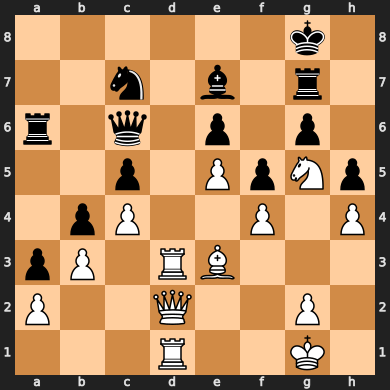

In [23]:
idx = 0
fens = read_fens('./test_fens/pairs_fens.txt')
FEN = fens[idx]
board = chess.Board(FEN)

engine = Engine("./stockfish_15_x64_avx2")
board_visualization = PairsBoardVisualization(board)
board_visualization.only_board()

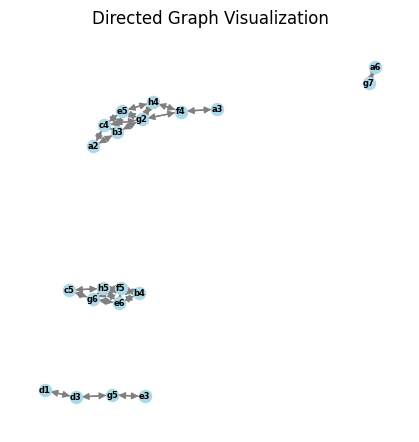

In [28]:
important_groups, optimal_move = pairs_important_groups_algorithm(FEN)

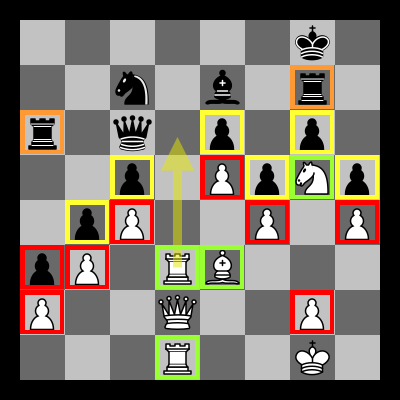

In [29]:
path = board_visualization.show_heatmap(important_groups, optimal_move)
display(Image(path))